In [8]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential, Model
# from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
# from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
#from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


from pre_process import *
from lightgbm_utils import *

from utils import *
%matplotlib inline

In [4]:
# Init some useful dirs
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir+'/../data/'

## Data

In [5]:
df_train = pd.read_csv(DATA_HOME_DIR+"application_train.csv")
df_test  = pd.read_csv(DATA_HOME_DIR+"application_test.csv")

In [6]:
# Fill in some blanks first
df_train['EXT_SOURCE_1'] = df_train['EXT_SOURCE_1'].fillna(0)
df_train['EXT_SOURCE_2'] = df_train['EXT_SOURCE_2'].fillna(0)
df_train['EXT_SOURCE_3'] = df_train['EXT_SOURCE_3'].fillna(0)

In [24]:
#df_train, df_test = append_poly_feature(in_dir=DATA_HOME_DIR, df_train=df_train, df_test=df_test)
df_train, df_test = append_bureau_data(in_dir=DATA_HOME_DIR, df_train=df_train, df_test=df_test)
df_train, df_test = append_previous_applications(in_dir=DATA_HOME_DIR, df_train=df_train, df_test=df_test)
df_train, df_test = append_pos_data(in_dir=DATA_HOME_DIR, df_train=df_train, df_test=df_test)
df_train, df_test = append_credit_card_data(in_dir=DATA_HOME_DIR, df_train=df_train, df_test=df_test)
df_train, df_test = append_installments_data(in_dir=DATA_HOME_DIR, df_train=df_train, df_test=df_test)

In [10]:
pd.options.display.max_columns = None

### Correlations
First lets look at the correlation with the target. This should help us isolate the important features

In [25]:
corrs = df_train.corr()

In [29]:
corrs = corrs.sort_values('TARGET', ascending = False)
# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(100))

,TARGET
TARGET,1.000000
EXT_SOURCE_2 DAYS_BIRTH,0.156030
EXT_SOURCE_2^2 DAYS_BIRTH,0.148845
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,0.147500
EXT_SOURCE_3^2 DAYS_BIRTH,0.128479
EXT_SOURCE_3 DAYS_BIRTH,0.124432
cc_bal_CNT_DRAWINGS_ATM_CURRENT,0.115949
DAYS_CREDIT_y,0.089729
DAYS_CREDIT_x,0.089729
cc_bal_AMT_BALANCE,0.087177


In [27]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(20))

,TARGET
EXT_SOURCE_1 EXT_SOURCE_3,-0.081716
EXT_SOURCE_1^2 EXT_SOURCE_3,-0.082041
EXT_SOURCE_1 EXT_SOURCE_3^2,-0.083022
EXT_SOURCE_1 EXT_SOURCE_2,-0.083668
EXT_SOURCE_1^2 EXT_SOURCE_2,-0.085753
EXT_SOURCE_1 EXT_SOURCE_2^2,-0.085993
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,-0.088886
EXT_SOURCE_3 DAYS_BIRTH^2,-0.115155
EXT_SOURCE_3_y,-0.119572
EXT_SOURCE_3_x,-0.119572


ValueError: array must not contain infs or NaNs

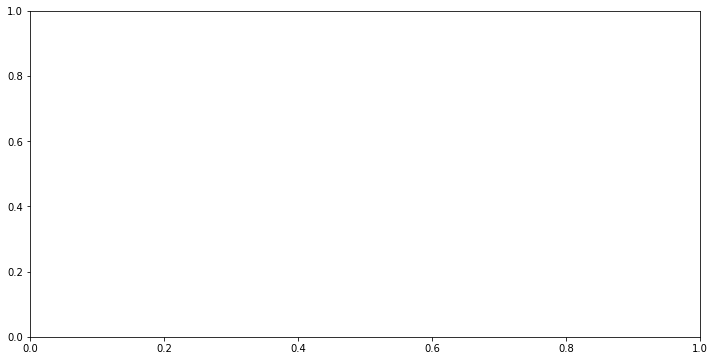

In [28]:
kde_target('DAYS_CREDIT_y', df_train)

In [ ]:
kde_target('EXT_SOURCE_2', df_train)

In [ ]:
kde_target('EXT_SOURCE_3', df_train)

## Feature Engineering

### Categrical data
First lets get the subset of columns to one hot  encode

In [ ]:
# Utility to add missing dummies in test set
def fix_missing_cols(in_train, in_test):
    missing_cols = set( in_train.columns ) - set( in_test.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        in_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    in_test = in_test[in_train.columns]
    return in_test

In [ ]:
categorical_cols = ['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE'
]


and now one hot encode. Ideally this would cover all the variations in the underlying data set (not just from the sample)

In [ ]:
df_train_enc = pd.get_dummies(df_train[categorical_cols])

In [ ]:
df_train_enc.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split( df_train_enc, df_train_y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape

In [ ]:
y_train.shape

### Numerical data

In [ ]:
df_num = df_train[['AMT_INCOME_TOTAL']]
x_norm = preprocessing.scale(df_num)
df_num['AMT_INCOME_TOTAL'] = x_norm
df_num.describe()

## Model Setup

In [ ]:
in_layers = 42
fd_layers = in_layers*2
learning_rate = 0.1

In [ ]:
model = Sequential()
model.add(Dense(fd_layers, input_dim=in_layers, activation='relu'))
model.add(Dense(int((fd_layers/2)), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])

In [ ]:
batch_size=64

In [ ]:
model.summary()

In [ ]:
from roc_callback import *
roc_cb = roc_callback(training_data=(x_train, y_train),validation_data=(x_test, y_test))

In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size=batch_size, callbacks=[roc_cb])

In [ ]:
model.optimizer.lr = 0.01

In [ ]:
model.fit(x_train, y_train, epochs=5, batch_size=batch_size, callbacks=[roc_cb])